In [8]:
#Import libraries
import csv
import cv2
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import sklearn

lines = []
#Read the csv file which contains the driving data from Udacity
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    #eliminate the information of first row
    for index, line in enumerate(reader):
        if index==0:
            continue
        else:
            lines.append(line)
print (len(lines))

#Read the csv file which contains the driving data of counter-clockwise lap
with open('data/driving_reverse.csv') as csvfile:
    reader = csv.reader(csvfile)
    for index, line in enumerate(reader):
        lines.append(line)
print (len(lines))

#Read the csv file which contains the driving data of recovery lap
with open('data/driving_recovery.csv') as csvfile:
    reader = csv.reader(csvfile)
    for index, line in enumerate(reader):
        lines.append(line)
print (len(lines))

8035
10847
12109


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

def generator(samples, correction=0.2, batch_size=32, threshold=0.6):
    num_samples = len(samples)
    print (num_samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        last_batch = num_samples//batch_size
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                steering_angle = float(batch_sample[3])
                file_paths = ['data/IMG/'+batch_sample[i].split('/')[-1] for i in range(3)]
                
                #import all the images from three cameras
                for file_path in file_paths:
                    img = cv2.imread(file_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #Convert the colorspace from BGR to RGB
                    images.append(img)
                    images.append(cv2.flip(img,1))      #Collect more data by flipping the image

                #Low Pass filter for steering angle to prevent from too much jitter
                if math.fabs(steering_angle) < threshold:
                    pass
                else:
                    if steering_angle>0:
                        steering_angle = threshold
                    else:
                        steering_angle = -threshold
                         
                #Steering angles from center camera
                angles.append(steering_angle)
                angles.append(-steering_angle)  #Steering angles should be opposed for flipped images
                #Steering angles from left camera
                angles.append(steering_angle+correction)
                angles.append(-(steering_angle+correction))
                #Steering angles from right camera
                angles.append(steering_angle-correction)
                angles.append(-(steering_angle-correction))

            #Convert data type from list to numpy.array
            X_data = np.array(images)
            y_data = np.array(angles)
            yield shuffle(X_data, y_data)

# next(train_generator)
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [25]:
# #creat dataset from images recored. 
# def Data_Generation(lines, multiple_cameras='off', correction=0.2):
#     images = []
#     steering_angles = []
#     if multiple_cameras=='off':
        
#         for line in lines[1:]:
#             source_path_center = line[0]
#             filename = source_path_center.split('/')[-1]
#             image_center = cv2.imread('data/IMG/{}'.format(filename))
#             images.append(image_center)
#             steering_angles.append(float(line[3]))
#         X_data = np.array(images)
#         y_data = np.array(steering_angles)
#         return X_data, y_data
    
#     elif multiple_cameras=='on':
#         for index, line in enumerate(lines[1:]):
#             steering_center = float(line[3])
#             steering_center_left = steering_center + correction
#             steering_center_right = steering_center - correction
#             steering_angles.extend([steering_center, steering_center_left, steering_center_right])
            
#             img_center = cv2.imread('data/IMG/{}'.format(line[0].split('/')[-1]))
#             img_left = cv2.imread('data/IMG/{}'.format(line[1].split('/')[-1]))
#             img_right = cv2.imread('data/IMG/{}'.format(line[2].split('/')[-1]))
            
#             images.append(img_center)
#             images.append(img_left)
#             images.append(img_right)

#         X_data = np.array(images)
#         y_data = np.array(steering_angles)
#         return X_data, y_data

# #flip the images and extend the original dataset
# def Data_Augmentation(X_data, y_data):
#     #flip the images
#     X_augmented = []
#     y_augmented = []
#     for i in range(int(len(y_data))):
#         image_flip = np.fliplr(X_data[i])
#         steer_angle_flip = -y_data[i]
#         X_augmented.append(image_flip)
#         y_augmented.append(steer_angle_flip)
#     #Combine the new data created by augmentation with the original training data set
#     X_data = np.concatenate((X_data, np.array(X_augmented)), axis=0)
#     y_data = np.concatenate((y_data, np.array(y_augmented)), axis=0)
#     return X_data, y_data

# X, y = Data_Generation(lines, multiple_cameras='off')
# X_data, y_data = Data_Augmentation(X, y)
# # X_data = Data_Process(X_data)
# print (X_data.shape, y_data.shape)


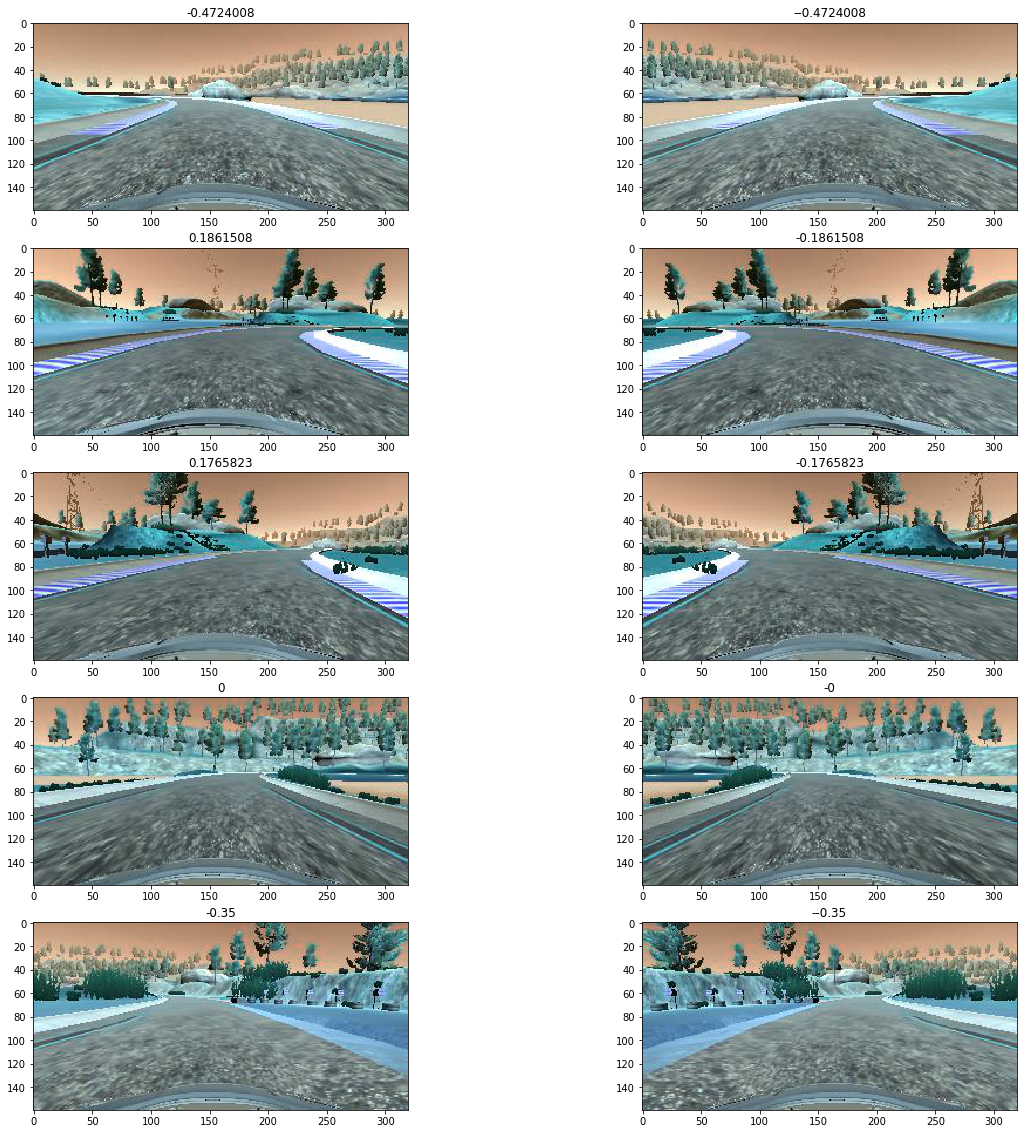

In [12]:
# #Randomly plot ten images from flipped dataset
fig = plt.figure(figsize=[20,20])
for num in range(5):
    index = random.randint(0, len(lines)-1)
    file_path = 'data/IMG/'+lines[index][0].split('/')[-1]
    img = cv2.imread(file_path)
    img_flip = cv2.flip(img,1)
    ax1= fig.add_subplot(5,2,2*num+1)
    plt.imshow(img)
    ax1.set_title(str(lines[index][3]))
    
    ax2= fig.add_subplot(5,2,2*num+2)
    plt.imshow(img_flip)
    ax2.set_title('-'+lines[index][3])
plt.show()
fig.savefig('examples/filpped-images.png')

In [28]:
#resize the original image from 160x320x3 to 32x32x3 and then normalize it
import keras
import gc
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(vertical_flip=True)
# datagen.fit(X_data)

def resize(x):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(x, (64, 64))

model = Sequential()
model.add(Lambda(resize, input_shape=(160,320,3), output_shape=(64,64,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Cropping2D(cropping=((20,10), (0,0))))

#simple testing network
# model.add(Flatten())
# model.add(Dense(1))

#LeNet 
# model.add(Convolution2D(6, 5,5, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Convolution2D(16, 5,5, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dense(120, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(84, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(1))


#NVIDIA Network
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))  #30x30x24
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))  #13x13x36
model.add(Convolution2D(48,3,3, activation='relu'))  #
model.add(Convolution2D(64,2,2, activation='relu'))  #
model.add(Convolution2D(64,2,2, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
          
model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch=6*len(train_samples), validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=10)

print (history_object)
model.save('model-filter.h5')
gc.collect()


Epoch 1/10
58122/58122 [==============================] - 49s - loss: 0.0238 - val_loss: 0.0191
Epoch 2/10
58122/58122 [==============================] - 48s - loss: 0.0196 - val_loss: 0.0182
Epoch 3/10
58122/58122 [==============================] - 48s - loss: 0.0176 - val_loss: 0.0163
Epoch 4/10
58122/58122 [==============================] - 48s - loss: 0.0160 - val_loss: 0.0167
Epoch 5/10
58122/58122 [==============================] - 48s - loss: 0.0147 - val_loss: 0.0180
Epoch 6/10
58122/58122 [==============================] - 48s - loss: 0.0136 - val_loss: 0.0167
Epoch 7/10
58122/58122 [==============================] - 48s - loss: 0.0125 - val_loss: 0.0175
Epoch 8/10
58122/58122 [==============================] - 48s - loss: 0.0116 - val_loss: 0.0142
Epoch 9/10
58122/58122 [==============================] - 48s - loss: 0.0109 - val_loss: 0.0163
Epoch 10/10
58122/58122 [==============================] - 48s - loss: 0.0105 - val_loss: 0.0161


99

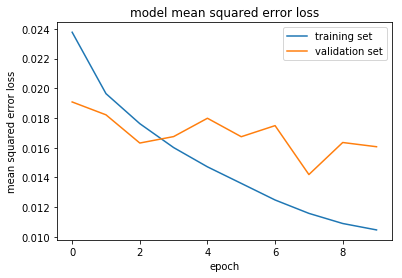

In [29]:
#Plot the loss 
plt.subplot(1,1,1)
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

plt.show()

In [ ]:
d